In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os, cv2
from torch.utils.data import Dataset, DataLoader

print("GPU:", torch.cuda.is_available())
print("Nibabel version:", nib.__version__)


GPU: True
Nibabel version: 5.3.2


FLAIR shape: (240, 240, 155)
Mask shape: (240, 240, 155)


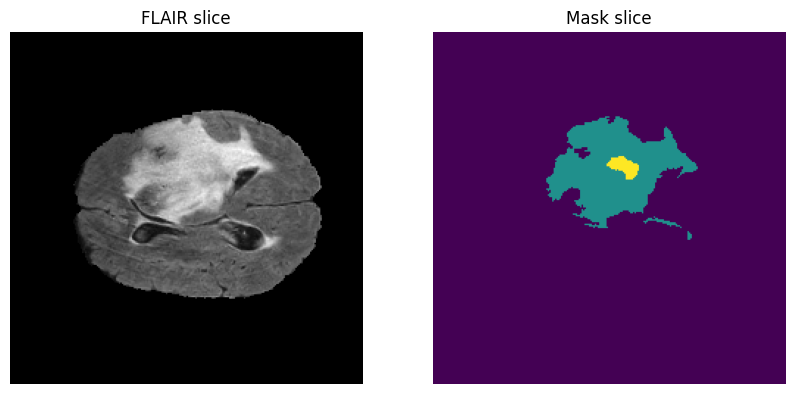

In [2]:
# Example MRI and segmentation paths
example_flair = r"..\data\BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii"
example_mask  = r"..\data\BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii"

# Load volumes
flair_img = nib.load(example_flair).get_fdata()
mask_img  = nib.load(example_mask).get_fdata()

print("FLAIR shape:", flair_img.shape)
print("Mask shape:", mask_img.shape)

# Visualize one slice
slice_idx = 80
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(flair_img[:,:,slice_idx], cmap='gray')
plt.title("FLAIR slice")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_img[:,:,slice_idx])
plt.title("Mask slice")
plt.axis('off')
plt.show()


In [8]:
import os
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
import glob

data_dir = r"..\data\BraTS2020_TrainingData"
out_images = r"..\data\processed\images"
out_masks  = r"..\data\processed\masks"

os.makedirs(out_images, exist_ok=True)
os.makedirs(out_masks, exist_ok=True)

patients = sorted(glob.glob(os.path.join(data_dir, "BraTS20_*")))

for p in tqdm(patients):
    pid = os.path.basename(p)
    flair_path = os.path.join(p, f"{pid}_flair.nii")
    seg_path   = os.path.join(p, f"{pid}_seg.nii")

    # Skip if segmentation file doesn’t exist
    if not os.path.exists(seg_path):
        print(f"Skipping {pid} (no segmentation file)")
        continue

    flair = nib.load(flair_path).get_fdata()
    mask  = nib.load(seg_path).get_fdata()

    for i in range(flair.shape[2]):  # iterate over slices
        img_slice  = flair[:, :, i]
        mask_slice = mask[:, :, i]

        if np.max(mask_slice) == 0:
            continue

        img_slice = cv2.resize(img_slice, (128,128))
        mask_slice = cv2.resize(mask_slice, (128,128), interpolation=cv2.INTER_NEAREST)
        img_slice = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        mask_slice = mask_slice.astype(np.uint8)

        cv2.imwrite(os.path.join(out_images, f"{pid}_slice_{i:03d}.png"), img_slice)
        cv2.imwrite(os.path.join(out_masks,  f"{pid}_slice_{i:03d}.png"), mask_slice)


 96%|████████████████████████████████████████████████████████████████████████████▋   | 354/369 [01:18<00:03,  4.57it/s]

Skipping BraTS20_Training_355 (no segmentation file)


100%|████████████████████████████████████████████████████████████████████████████████| 369/369 [01:21<00:00,  4.53it/s]


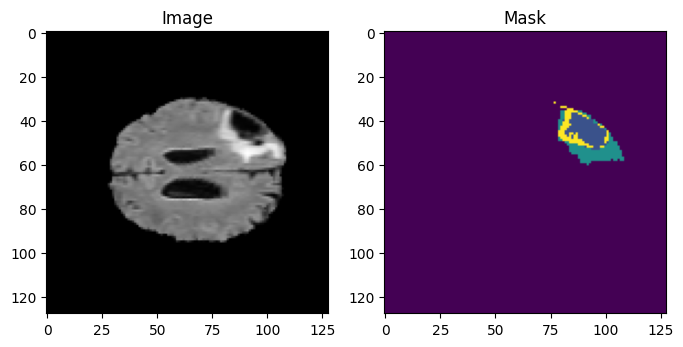

In [9]:
import random
img_files = os.listdir(out_images)
r = random.choice(img_files)

img = cv2.imread(os.path.join(out_images, r), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(out_masks, r), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(mask); plt.title('Mask')
plt.show()


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2, os, numpy as np
from sklearn.model_selection import train_test_split

# Paths
IMG_DIR  = r"..\data\processed\images"
MASK_DIR = r"..\data\processed\masks"

imgs  = sorted(os.listdir(IMG_DIR))
masks = sorted(os.listdir(MASK_DIR))
print("Total samples:", len(imgs))

# Train-validation split (80-20)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    imgs, masks, test_size=0.2, random_state=42
)

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.GaussNoise(p=0.2),
])
# val_transform=A.Compose([])
class BrainMRIDataset(Dataset):
    def __init__(self, img_list, mask_list, img_dir, mask_dir, transform=None):
        self.img_list, self.mask_list = img_list, mask_list
        self.img_dir, self.mask_dir = img_dir, mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_list[idx]), cv2.IMREAD_GRAYSCALE)

        img  = img / 255.0
        img = img.astype(np.float32)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
           augmented = self.transform(image=img, mask=mask)
           img, mask = augmented['image'], augmented['mask']

        img  = np.expand_dims(img, axis=0)   # 1×128×128
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

train_ds = BrainMRIDataset(train_imgs, train_masks, IMG_DIR, MASK_DIR, transform=train_transform)
val_ds   = BrainMRIDataset(val_imgs, val_masks, IMG_DIR, MASK_DIR)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8)


Total samples: 24354


C:\Users\Arvind\anaconda3\envs\brats\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(1, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(64, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = DoubleConv(64, 32)
        self.up3 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec3 = DoubleConv(32, 16)

        self.out = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool1(c1))
        c3 = self.down3(self.pool2(c2))
        b  = self.bridge(self.pool3(c3))

        u1 = self.up1(b)
        u1 = torch.cat([u1, c3], dim=1)
        d1 = self.dec1(u1)

        u2 = self.up2(d1)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.dec2(u2)

        u3 = self.up3(d2)
        u3 = torch.cat([u3, c1], dim=1)
        d3 = self.dec3(u3)

        return torch.sigmoid(self.out(d3))


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            val_loss += criterion(preds, masks).item()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss/len(train_loader):.4f}  "
          f"Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/10]  Train Loss: 0.3124  Val Loss: 0.1486
Epoch [2/10]  Train Loss: 0.0893  Val Loss: 0.0495
Epoch [3/10]  Train Loss: 0.0381  Val Loss: 0.0266
Epoch [4/10]  Train Loss: 0.0253  Val Loss: 0.0194
Epoch [5/10]  Train Loss: 0.0215  Val Loss: 0.0178
Epoch [6/10]  Train Loss: 0.0202  Val Loss: 0.0165
Epoch [7/10]  Train Loss: 0.0197  Val Loss: 0.0163
Epoch [8/10]  Train Loss: 0.0191  Val Loss: 0.0163
Epoch [9/10]  Train Loss: 0.0188  Val Loss: 0.0149
Epoch [10/10]  Train Loss: 0.0186  Val Loss: 0.0156


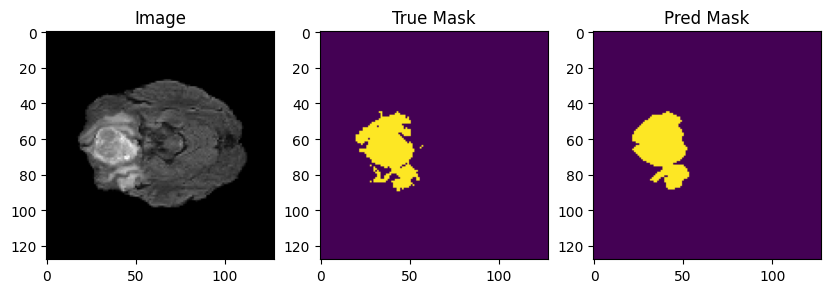

In [10]:
model.eval()
import matplotlib.pyplot as plt

for imgs, masks in val_loader:
    imgs = imgs.to(device)
    preds = model(imgs)
    preds = (preds > 0.5).float()

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(imgs[0,0].cpu(), cmap='gray'); plt.title('Image')
    plt.subplot(1,3,2); plt.imshow(masks[0,0].cpu()); plt.title('True Mask')
    plt.subplot(1,3,3); plt.imshow(preds[0,0].cpu()); plt.title('Pred Mask')
    plt.show()
    break


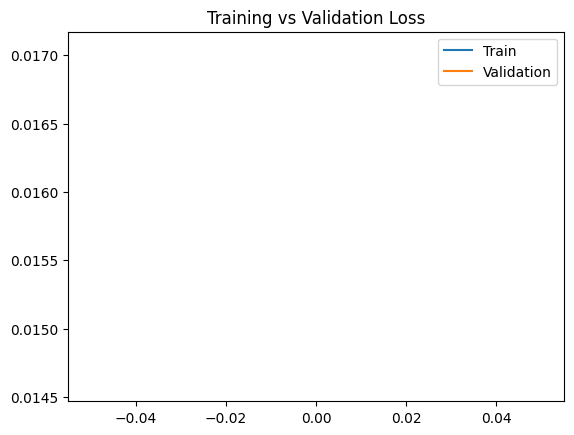

In [14]:
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("../outputs/loss_curve.png", dpi=300)


In [13]:
num_epochs = 30
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            val_loss += criterion(preds, masks).item()
    val_loss /= len(val_loader)
    val_loss_list.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")


Epoch [1/30]  Train Loss: 0.3478  Val Loss: 0.1419
Epoch [2/30]  Train Loss: 0.0843  Val Loss: 0.0439
Epoch [3/30]  Train Loss: 0.0354  Val Loss: 0.0245
Epoch [4/30]  Train Loss: 0.0246  Val Loss: 0.0195
Epoch [5/30]  Train Loss: 0.0216  Val Loss: 0.0174
Epoch [6/30]  Train Loss: 0.0204  Val Loss: 0.0167
Epoch [7/30]  Train Loss: 0.0197  Val Loss: 0.0165
Epoch [8/30]  Train Loss: 0.0194  Val Loss: 0.0159
Epoch [9/30]  Train Loss: 0.0191  Val Loss: 0.0165
Epoch [10/30]  Train Loss: 0.0187  Val Loss: 0.0152
Epoch [11/30]  Train Loss: 0.0183  Val Loss: 0.0173
Epoch [12/30]  Train Loss: 0.0181  Val Loss: 0.0145
Epoch [13/30]  Train Loss: 0.0181  Val Loss: 0.0147
Epoch [14/30]  Train Loss: 0.0180  Val Loss: 0.0157
Epoch [15/30]  Train Loss: 0.0177  Val Loss: 0.0151
Epoch [16/30]  Train Loss: 0.0176  Val Loss: 0.0146
Epoch [17/30]  Train Loss: 0.0174  Val Loss: 0.0144
Epoch [18/30]  Train Loss: 0.0173  Val Loss: 0.0140
Epoch [19/30]  Train Loss: 0.0172  Val Loss: 0.0150
Epoch [20/30]  Train 

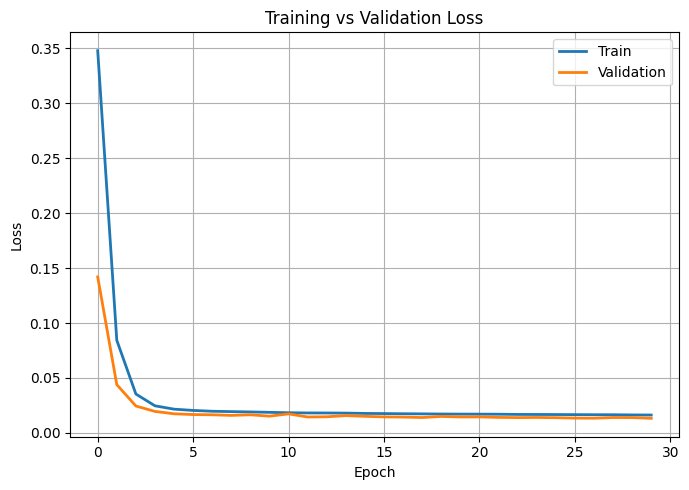

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(train_loss_list, label="Train", linewidth=2)
plt.plot(val_loss_list, label="Validation", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/loss_curve.png", dpi=300)
plt.show()


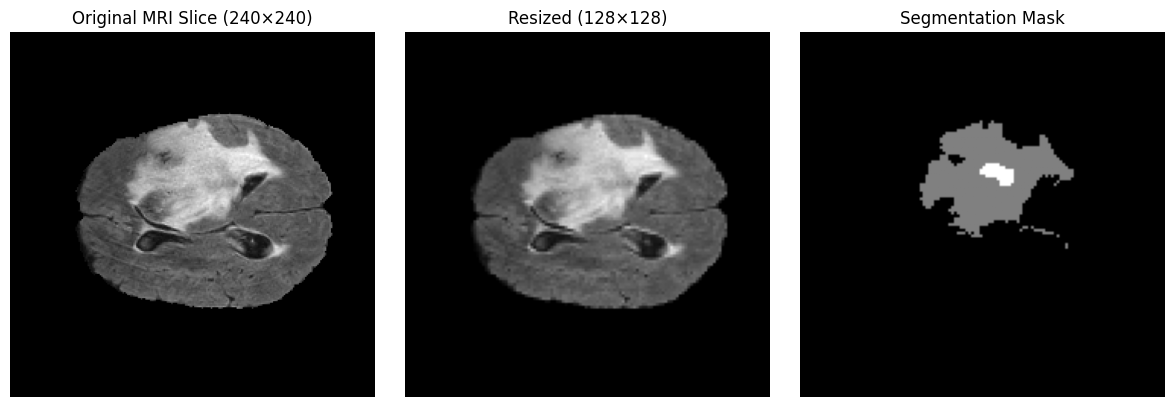

In [16]:
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1️⃣ Load raw MRI and mask (before preprocessing)
flair_path = r"..\data\BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii"
mask_path  = r"..\data\BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii"

flair = nib.load(flair_path).get_fdata()
mask  = nib.load(mask_path).get_fdata()

# 2️⃣ Pick a middle slice
slice_idx = 80
raw_img = flair[:,:,slice_idx]
raw_mask = mask[:,:,slice_idx]

# 3️⃣ Preprocess
resized_img = cv2.resize(raw_img, (128,128))
resized_mask = cv2.resize(raw_mask, (128,128), interpolation=cv2.INTER_NEAREST)

# 4️⃣ Normalize
norm_img = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# 5️⃣ Display the pipeline
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(raw_img, cmap='gray')
axes[0].set_title("Original MRI Slice (240×240)")

axes[1].imshow(resized_img, cmap='gray')
axes[1].set_title("Resized (128×128)")

axes[2].imshow(resized_mask, cmap='gray')
axes[2].set_title("Segmentation Mask")

for ax in axes: ax.axis('off')

plt.tight_layout()
plt.savefig("../outputs/preprocess_example.png", dpi=300)
plt.show()


### import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")

def box(x, y, text, color):
    ax.add_patch(FancyBboxPatch((x, y), 1.8, 0.8,
                                boxstyle="round,pad=0.1",
                                linewidth=2, edgecolor=color, facecolor=color, alpha=0.3))
    ax.text(x + 0.9, y + 0.4, text, ha='center', va='center', fontsize=11, weight='bold')

def arrow(x1, y1, x2, y2):
    ax.add_patch(FancyArrowPatch((x1, y1), (x2, y2),
                                 arrowstyle='->', mutation_scale=15, linewidth=2, color='black'))

# Boxes (process steps)
box(0, 0, "MRI Input\n(FLAIR, T1, T2, T1CE)", "lightblue")
box(2.2, 0, "Preprocessing\n(Normalize, Resize, Augment)", "lightgreen")
box(4.4, 0, "U-Net Model\n(Encoder–Decoder CNN)", "lightyellow")
box(6.6, 0, "Segmentation Output\n(Tumor Mask)", "lightcoral")

# Arrows connecting them
arrow(1.8, 0.4, 2.2, 0.4)
arrow(4.0, 0.4, 4.4, 0.4)
arrow(6.2, 0.4, 6.6, 0.4)

plt.tight_layout()
plt.savefig("../outputs/pipeline_flowchart.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

# --- Paths to one validation image and mask ---
img_path = r"..\data\processed\images\BraTS20_Training_001_slice_080.png"
mask_path = r"..\data\processed\masks\BraTS20_Training_001_slice_080.png"

# Load image and mask
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img_norm = img / 255.0

# --- Load your trained model ---
model.eval()
with torch.no_grad():
    inp = torch.tensor(img_norm[np.newaxis, np.newaxis, :, :], dtype=torch.float32).to(device)
    pred = model(inp).cpu().numpy()[0,0,:,:]
pred_mask = (pred > 0.5).astype(np.uint8)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(10,4))

axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original MRI")
axes[1].imshow(mask_true, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title("Predicted Mask")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.savefig("../outputs/results_example.png", dpi=300)
plt.show()


NameError: name 'model' is not defined